In [1]:
import random
import numpy as np
import pandas as pd
import manage_data as md
import preprocessing as pp
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics

In [2]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, filename='cm'):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20, fontstyle='oblique')
    #plt.colorbar()
    ax = plt.subplot()
    tick_marks = np.arange(2)
    labels = ['Sticking', 'Fine']
    plt.xticks(tick_marks, labels, rotation=45, fontsize=20)
    plt.yticks(tick_marks, labels, fontsize=20)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    width, height = cm.shape
    for x in xrange(width):
        xx = np.round(x, 2)
        for y in xrange(height):
            yy = np.round(y, 2)
            valeur = str(int(np.round(100 * cm[x][y],0)))+'%'
            ax.annotate(valeur, xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size=30)
    plt.savefig('./images/cm/' + filename + '.png')
    #plt.text(0.1, 0.1,'Caption')

def concat_df(coil_list):
    big_df = md.importPeak(coil_list[0]).dropna()
    for coil in coil_list[1:]:
        df = md.importPeak(coil).dropna()
        big_df = pd.concat([big_df, df], ignore_index=True)
    return big_df

def create_DB(df):
    feature_col = ['Ximf0', 'Ximf1', 'Ximf2', 'Yimf0', 'Yimf1', 'Yimf2', 'thickness', 'speed']
    X = df[feature_col].values
    Y = df[['sticking']]
    Y = np.array(Y.sticking.values[:], dtype=bool)
    return X, Y

def random_sample(coil_list):
    df = concat_df(coil_list)
    sticking_index = list(df[df.sticking==True].index)
    non_sticking_index = list(df[df.sticking==False].index)
    group_of_items = non_sticking_index               # a sequence or set will work here.
    num_to_select = len(df[df.sticking==True])        # set the number to select here.
    list_of_random_items = random.sample(group_of_items, num_to_select)
    list_of_random_items
    ind = sticking_index+list_of_random_items
    return df.loc[ind]

def random_coils_selection(coil_list, ratio=0.5):
    aux  = list(coil_list)
    random.shuffle(aux)
    n = int(ratio * len(aux))+1
    return aux[:n], aux[n:]

def result_per_coil(coil_list, estimator):
    sum_true = []
    sum_predict = []
    for coil in coil_list:
        df_test = concat_df([coil])
        X_test, Y_true = create_DB(df_test)
        Y_predict = estimator.predict(X_test)
        sum_true.append(sum(Y_true))
        sum_predict.append(sum(Y_predict))
    d = {'truth':sum_true, 'prediction':sum_predict}
    result = pd.DataFrame(d, index=coil_list)
    return result, np.array(sum_true), np.array(sum_predict)

# About DB

In [3]:
all_coils = list( set(range(88)) - set([31]) )
k = 0

In [4]:
learning_sticking_coil = sorted([7, 28, 49, 50, 78, 79, 81, 82, 62, 74])
big_sticking_error = [13, 38, 40, 65] + [29, 34, 37, 44, 52, 53, 56] + [4, 17, 20]
learning_fine_coils = sorted([10, 24, 25, 30, 33, 42, 46, 47, 48, 85])
big_fine_error = [36, 77]+[1, 5, 11, 15, 45, 57, 75] + [0, 12, 14, 18, 26]
big_fine_error += [35, 39, 41, 51, 54, 59, 63, 68, 69, 70, 73, 76, 84, 87]
learning_coils = learning_sticking_coil + learning_fine_coils
learning_coils += big_fine_error
learning_coils += big_sticking_error
testing_coils = list(set(range(88)) - set(learning_coils) - set({31}))
n = len(learning_coils)+len(testing_coils)
nl = int(np.round(len(learning_coils)*100./n,0))
nt = int(np.round(len(testing_coils)*100./n,0))
print(str(nl)+'% learning coils: '+str(len(learning_coils)))
print(str(nt)+'% testing coils: '+str(len(testing_coils)))

71% learning coils: 62
29% testing coils: 25


In [1]:
learning_coils, testing_coils = random_coils_selection(all_coils, ratio=0.50)
n = len(learning_coils)+len(testing_coils)
nl = int(np.round(len(learning_coils)*100./n,0))
nt = int(np.round(len(testing_coils)*100./n,0))
print(str(nl)+'% learning coils: '+str(len(learning_coils)))
print(str(nt)+'% testing coils: '+str(len(testing_coils)))
k += 1

NameError: name 'random_coils_selection' is not defined

In [2]:
graph_title_suffix = '\n 50/50'

In [3]:
df_total = concat_df(all_coils)
df_total_train = concat_df(learning_coils)
df_total_test = concat_df(testing_coils)
df_total_train.head()

NameError: name 'concat_df' is not defined

# Classifier setting

In [53]:
X_train, Y_train = create_DB(df_total_train)
X_test, Y_true = create_DB(df_total_test)
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(X_train, Y_train)
tree.export_graphviz(clf, out_file='tree.dot')   

# Result per 4s slice

[[114 216]
 [107 749]]
[[ 0.34545455  0.65454545]
 [ 0.125       0.875     ]]


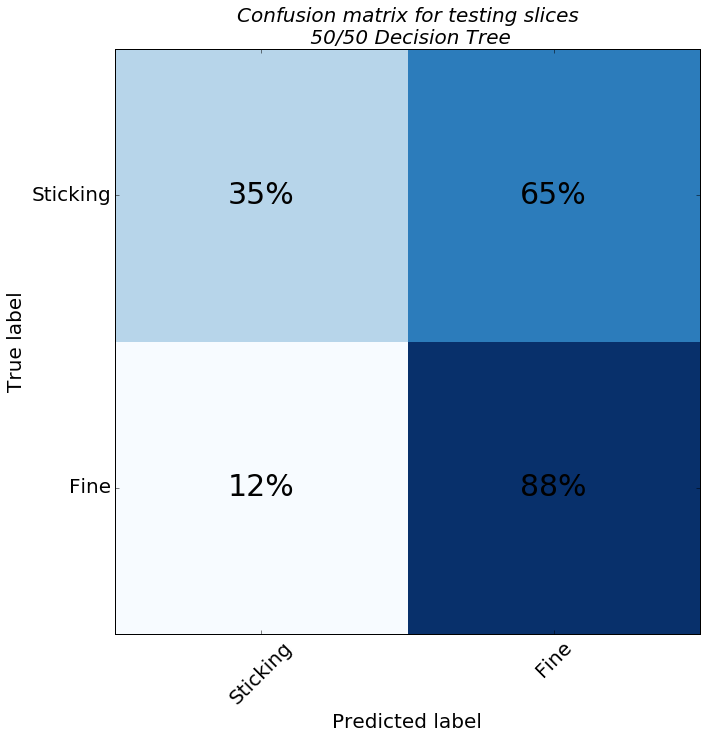

In [54]:
Y_predict = clf.predict(X_test)
cm = metrics.confusion_matrix(Y_true, Y_predict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing slices'+graph_title_suffix+' Decision Tree'
plot_confusion_matrix(cm_normalized, title=cm_title, filename='dt_slices_rand'+str(k))
print(cm)
print(cm_normalized)

# Show learning DB

## On coils

[[16  1]
 [ 3 24]]
[[ 0.94117647  0.05882353]
 [ 0.11111111  0.88888889]]


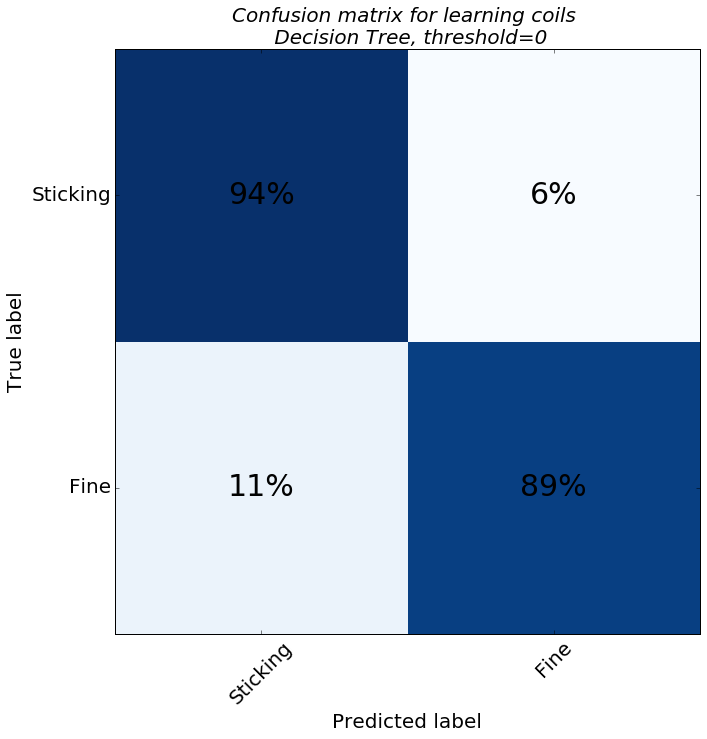

In [55]:
threshold = 0
suffix = 'threshold='+str(threshold)
result_DB, sumtrue, sumpredict = result_per_coil(learning_coils, clf)
ytrue = np.greater(sumtrue, 0)
ypredict = np.greater(sumpredict, threshold)
cm = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(
                    cm_normalized, 
                    'Confusion matrix for learning coils \n Decision Tree, '+suffix,
                    filename='dt_db_coils_rand'+str(k)
                    )
print(cm)
print(cm_normalized)

## On 4s slices

[[ 149   66]
 [  14 1027]]
[[ 0.69302326  0.30697674]
 [ 0.01344861  0.98655139]]


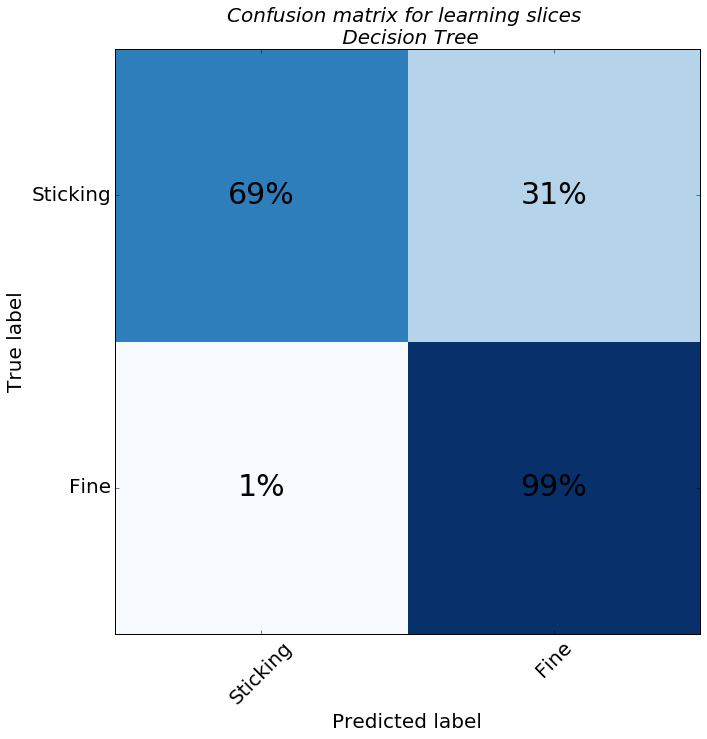

In [56]:
Y_predict = clf.predict(X_train)
cm = metrics.confusion_matrix(Y_train, Y_predict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(
                        cm_normalized, 
                        'Confusion matrix for learning slices \n Decision Tree',
                        filename='dt_db_slices_rand'+str(k)
                        )
print(cm)
print(cm_normalized)

# Result per coil

In [57]:
result, sumtrue, sumpredict = result_per_coil(testing_coils, clf)

[[15  7]
 [12  9]]
[[ 0.68181818  0.31818182]
 [ 0.57142857  0.42857143]]


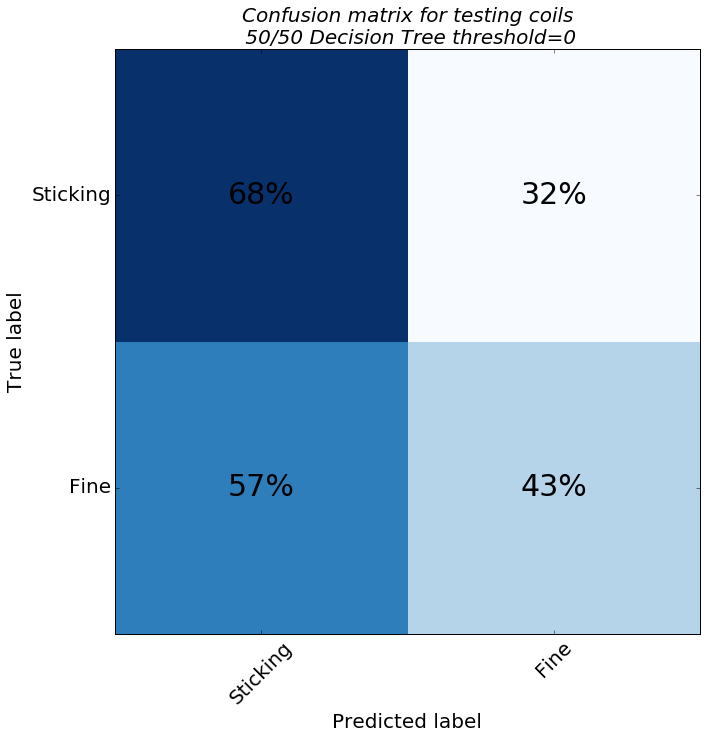

In [68]:
threshold = 0
suffix = ' Decision Tree threshold='+str(threshold)
ytrue = np.greater(sumtrue, 0)
ypredict = np.greater(sumpredict, threshold)
cm = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing coils'+graph_title_suffix+suffix
plot_confusion_matrix(cm_normalized, title=cm_title, filename='dt_coils_rand'+str(k))
print(cm)
print(cm_normalized)

## Sticking detection failure

### False negative

In [59]:
selection = result[(result.truth>0) & (result.prediction<threshold+1)]
l = sorted(list(selection.index))
print(selection)
print(l)
print(len(l))
print(selection.prediction.mean())
print(selection.truth.mean())

    prediction  truth
52           0      4
83           0     12
20           0     10
4            0      5
53           0      8
44           0      2
74           0     12
[4, 20, 44, 52, 53, 74, 83]
7
0.0
7.57142857143


### False positive

In [60]:
selection = result[(result.truth==0) & (result.prediction>threshold)]
l2 = sorted(list(selection.index))
print(selection)
print(l2)
print(len(l2))
print(selection.prediction.mean())
np.abs(sumtrue-sumpredict).mean()

    prediction  truth
26           2      0
5            3      0
63           1      0
54           1      0
67           2      0
33          11      0
55           4      0
1           26      0
60           3      0
39           1      0
57          21      0
25           8      0
[1, 5, 25, 26, 33, 39, 54, 55, 57, 60, 63, 67]
12
6.91666666667


6.7674418604651159

## Data representation

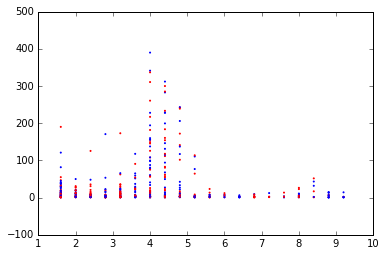

In [61]:
# this formatter will label the colorbar with the correct target names
#formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(df_total.Ximf2, df_total.Yimf2, df_total.sticking, color=["b", "r"])
#plt.colorbar(ticks=[0, 1, 2], format=formatter)
#plt.xlabel(iris.feature_names[x_index])
#plt.ylabel(iris.feature_names[y_index])

# Old code results

[[ 9  3]
 [17 15]]
[[ 0.75     0.25   ]
 [ 0.53125  0.46875]]


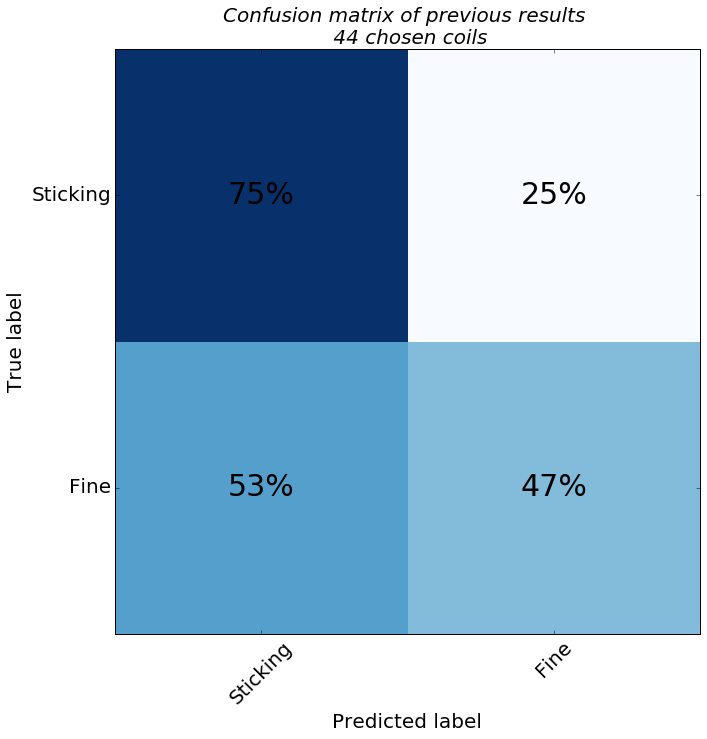

In [62]:
ytrue_old = np.ones(44).astype(bool)
ytrue_old[12:] = False
ytest_old = np.ones(44).astype(bool)
ytest_old[12:] = False
ytest_old[:3] = False
ytest_old[-17:] = True
sum(ytrue_old)
sum(ytest_old)
cm = metrics.confusion_matrix(ytrue_old, ytest_old, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(
                        cm_normalized, 
                        'Confusion matrix of previous results \n 44 chosen coils',
                        filename='cm_old'
                        )
print(cm)
print(cm_normalized)

# Plot sticking and prediction per coil

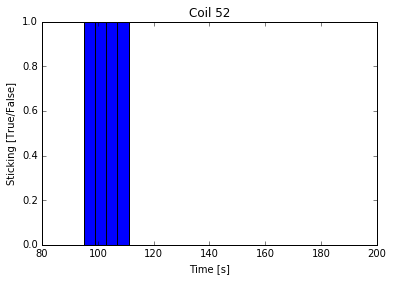

In [63]:
coil = l[3] #testing_coils[13]
df_raw = md.import_data(coil)
df_peak = md.importPeak(coil)
df_one_coil = concat_df([coil])
X_coil, Y_coil = create_DB(df_one_coil)
Y_pred_coil = clf.predict(X_coil)
df_one_coil['prediction'] = Y_pred_coil
x = (df_one_coil.time_begin.values + df_one_coil.time_end.values)/2.
plt.title('Coil '+str(coil))
plt.bar(x, df_one_coil.sticking.values,4)
plt.bar(x, 1./2*df_one_coil.prediction.values,4,color='g')
plt.xlabel('Time [s]')
plt.ylabel('Sticking [True/False]')

In [64]:
selection = result[(result.truth>0) & (result.prediction<threshold+1)]
l = sorted(list(selection.index))
print(selection)
print(l)
print(len(l))
print(selection.prediction.mean())
print(selection.truth.mean())

    prediction  truth
52           0      4
83           0     12
20           0     10
4            0      5
53           0      8
44           0      2
74           0     12
[4, 20, 44, 52, 53, 74, 83]
7
0.0
7.57142857143


# K-Means

In [65]:
from sklearn import cluster
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit_transform(X_train)
k_means = cluster.KMeans(n_clusters=2)
k_means.fit(X_train)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

ValueError: Supply a 'c' kwarg or a 'color' kwarg but not both; they differ but their functionalities overlap.

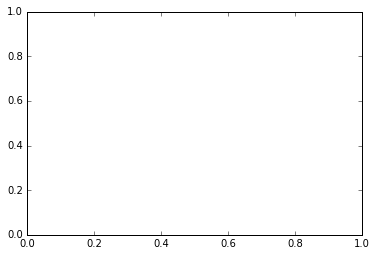

In [66]:
axeX = 0
axeY = axeX + 3
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.scatter(X_train[:, axeX], X_train[:, axeY], c=k_means.labels_, color=['b', 'r'])

In [ ]:
fig = plt.figure(2)
ax = fig.add_subplot(111)
ax.scatter(X_train[:, axeX], X_train[:, axeY], c=Y_train.astype(int), color=['b', 'r'])

# K-means result per 4s slices

In [ ]:
Y_predict = k_means.predict(X_test)
cm = metrics.confusion_matrix(Y_true, Y_predict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing slices'+graph_title_suffix+' K-Means'
plot_confusion_matrix(
    cm_normalized, 
    title=cm_title, 
    filename='kmeans_slices_rand'+str(k)
)
print(cm)
print(cm_normalized)

In [ ]:
result, sumtrue, sumpredict = result_per_coil(testing_coils, estimator=k_means)

In [ ]:
threshold = 0
ytrue = np.greater(sumtrue, 0)
ypredict = np.greater(sumpredict, threshold)
cm = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing coils'+graph_title_suffix+' K-Means'
plot_confusion_matrix(
    cm_normalized, 
    title=cm_title, 
    filename='kmeans_coils_rand'+str(k)
)
print(cm)
print(cm_normalized)

# K-means sticking detection failure

## False negative

In [ ]:
selection = result[(result.truth>0) & (result.prediction<threshold+1)]
lkmeans = sorted(list(selection.index))
print(selection)
print(lkmeans)
print(len(lkmeans))
print(selection.prediction.mean())
print(selection.truth.mean())

## False positive

In [ ]:
selection = result[(result.truth==0) & (result.prediction>threshold)]
lkmeans2 = sorted(list(selection.index))
print(selection)
print(lkmeans2)
print(len(lkmeans2))
print(selection.prediction.mean())

In [ ]:
coil = 6 #testing_coils[13]
df_raw = md.import_data(coil)
df_peak = md.importPeak(coil)
df_one_coil = concat_df([coil])
X_coil, Y_coil = create_DB(df_one_coil)
Y_pred_coil = k_means.predict(X_coil)
df_one_coil['prediction'] = Y_pred_coil
x = (df_one_coil.time_begin.values + df_one_coil.time_end.values)/2.
plt.title('Coil '+str(coil))
plt.bar(x, df_one_coil.sticking.values,4)
plt.bar(x, 1./2*df_one_coil.prediction.values,4,color='g')
plt.xlabel('Time [s]')
plt.ylabel('Sticking [True/False]')